Include results for Version II
(we save as *_original.npy)

In [1]:
# 4/6/23
# KM Altenburger

# steps for downloading repo internally; run w/ "grasp_workflows kernel"
# sudo feature install ttls_fwdproxy
# mgt import --src-type pypi sdist
# mgt import --src-type pypi nvidia-cublas-cu11==11.10.3.66
# mgt import --src-type pypi ogb

import sys

sys.path.insert(0, "/home/kaltenburger/fbsource/ogb")
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import ogb
import pandas as pd
import torch
#import torch_geometric
from ogb.nodeproppred import NodePropPredDataset
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, log_loss, precision_recall_curve, roc_auc_score
from sklearn.model_selection import train_test_split


Bad key "axes.color_cycle" on line 214 in
/home/kaltenburger/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


I0410 214320.768 _utils_internal.py:179] NCCL_DEBUG env var is set to None


I0410 214320.769 _utils_internal.py:197] NCCL_DEBUG is forced to WARN from None


### read & set-up dataset


In [2]:
dataset = NodePropPredDataset(name='ogbn-proteins')
g = dataset.graph # get edgelist and graph metadata
y = dataset.labels # outcomes
node_species_df = pd.DataFrame({'node_id':range(len(g['node_species'].flatten())), 'node_species': g['node_species'].flatten()})
node_species_df.head()

,node_id,node_species
0,0,3702
1,1,3702
2,2,3702
3,3,3702
4,4,3702


In [3]:
# create edgelist
edge_list_df = pd.DataFrame(g["edge_index"].T)
edge_list_df.columns = ['src','dst']
edge_list_df.head()

,src,dst
0,1,96401
1,96401,1
2,1,68343
3,68343,1
4,1,125069


In [4]:
# sanity check on inter-species connections
edge_list_df_check = edge_list_df.merge(node_species_df, how = 'left', left_on = 'src', right_on = 'node_id')
edge_list_df_check.drop('node_id', axis = 1, inplace=True)
edge_list_df_check = edge_list_df_check.merge(node_species_df, how = 'left', left_on = 'dst', right_on = 'node_id')
edge_list_df_check.drop('node_id', axis = 1, inplace=True)
#edge_list_df_check.head()
print(np.mean(edge_list_df_check['node_species_x']==edge_list_df_check['node_species_y']))
print(np.mean(edge_list_df_check['node_species_x']!=edge_list_df_check['node_species_y']))

0.8059610954678583


0.1940389045321417


In [5]:
# edge weights
edge_w = pd.DataFrame(g['edge_feat'])
w0 = np.mean(edge_w,1) # average edge weight
#w0 = edge_w[3]
edge_list_df['weight'] = w0
edge_list_df.head()

,src,dst,weight
0,1,96401,0.0635
1,96401,1,0.0635
2,1,68343,0.0635
3,68343,1,0.0635
4,1,125069,0.0635


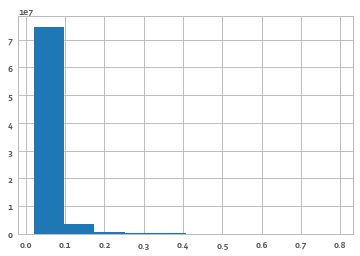

In [6]:
plt.hist(edge_list_df.weight)
plt.show()

In [7]:
y0 = pd.DataFrame(y)
#y0 = y0.iloc[:, 0:25]  # part I
#y0 = y0.iloc[:,25:50] # part II
y0 = y0.iloc[:,50:112] # part II
y0["node_id"] = range(len(y0[50]))

split_idx = dataset.get_idx_split()
train_idx, valid_idx, test_idx = (
    split_idx["train"],
    split_idx["valid"],
    split_idx["test"],
)

X_train = y0["node_id"].iloc[train_idx]
y_train = y0.iloc[train_idx]

X_valid = y0["node_id"].iloc[valid_idx]
X_test = y0["node_id"].iloc[test_idx]
y_valid = y0.iloc[valid_idx]
y_test = y0.iloc[test_idx]

# merge in labels for training nodes on a user's connections
relevant_edges_tmp = edge_list_df.merge(
    y_train, left_on="dst", right_on="node_id", how="left"
)

In [8]:
# set-up loop
rocauc_v1_ud_w = []
rocauc_v2_ud_w = []


# for i in range(0, 25): # part I
# for i in range(25, 50): # part II
for i in range(50, 112):  # part III
    print(i)
    relevant_edges = relevant_edges_tmp[["src", "dst", "weight", "node_id", i]]
    relevant_edges.columns = ["src", "dst", "weight", "node_id", "y"]
    label1 = relevant_edges.groupby(["src"])["y"].sum().reset_index()
    labeltotal = relevant_edges.groupby(["src"])["y"].count().reset_index()
    relevant_edgelist = labeltotal.merge(label1, on="src")
    relevant_edgelist["label_0"] = relevant_edgelist["y_x"] - relevant_edgelist["y_y"]
    relevant_edgelist.rename(columns={"y_y": "label_1"}, inplace=True)
    relevant_edgelist.drop(["y_x"], axis=1, inplace=True)

    ## v1 - undirected, weighted
    normalizer = pd.DataFrame(y_train[i].value_counts(normalize=True, ascending=True))

    # step 1 - one hop scores
    step1_one_hop_scores = pd.DataFrame(
        {
            "src": relevant_edgelist.src,
            "frac": np.log(
                (relevant_edgelist["label_1"] + 1) / (relevant_edgelist["label_0"] + 1)
            )
            * list((normalizer.iloc[0]) / (normalizer.iloc[1]))[0],
        }
    )

    # step 2 - two hop scores
    two_hop_stg = relevant_edges.merge(
        step1_one_hop_scores, left_on="dst", right_on="src", how="inner"
    )

    print(np.shape(two_hop_stg))

    interval = pd.DataFrame(
        two_hop_stg.weight.quantile([0.25, 0.5, 0.75])
    ).reset_index()
    interval.columns = ["interval", "weight"]

    two_0 = (
        two_hop_stg[two_hop_stg.weight <= interval.weight[0]]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )
    two_1 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[0])
            & (two_hop_stg.weight <= interval.weight[1])
        ]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )
    two_2 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[1])
            & (two_hop_stg.weight <= interval.weight[2])
        ]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )
    two_3 = (
        two_hop_stg[(two_hop_stg.weight > interval.weight[2])]
        .groupby(["src_x"])["frac"]
        .sum()
        .reset_index()
    )

    two_hop_v1 = two_0.merge(two_1, how="outer", on="src_x").fillna(0)
    two_hop_v1 = two_hop_v1.merge(two_2, how="outer", on="src_x").fillna(0)
    two_hop_v1 = two_hop_v1.merge(two_3, how="outer", on="src_x").fillna(0)
    two_hop_v1.columns = ["src_x", "frac1", "frac2", "frac3", "frac4"]
    two_hop_v1_valid = two_hop_v1.merge(
        y_valid, left_on="src_x", right_on="node_id", how="right"
    )

    clf = LogisticRegression(random_state=0).fit(
        two_hop_v1_valid[["frac1", "frac2", "frac3", "frac4"]], two_hop_v1_valid[i]
    )

    pred_v1 = y_test.merge(two_hop_v1, right_on="src_x", left_on="node_id", how="left")
    print(
        "roc-auc, v1: ",
        roc_auc_score(
            pred_v1[i],
            clf.predict_proba(pred_v1[["frac1", "frac2", "frac3", "frac4"]])[:, 1],
        ),
    )
    print("baseline, v1: ", np.mean(pred_v1[i]), len(pred_v1[i]))
    rocauc_v1_ud_w.append(
        roc_auc_score(
            pred_v1[i],
            clf.predict_proba(pred_v1[["frac1", "frac2", "frac3", "frac4"]])[:, 1],
        )
    )

    ## v2 undirected, weighted
    W = 4
    interval = pd.DataFrame(
        relevant_edges.weight.quantile([0.25, 0.5, 0.75])
    ).reset_index()
    interval.columns = ["interval", "weight"]

    relevant_edgelist_dict = {}
    for w in range(W):
        if w == 0:
            idx = relevant_edges.weight <= interval.weight[0]
        if w == 1:
            idx = (relevant_edges.weight > interval.weight[0]) & (
                relevant_edges.weight <= interval.weight[1]
            )
        if w == 2:
            idx = (relevant_edges.weight > interval.weight[1]) & (
                relevant_edges.weight <= interval.weight[2]
            )
        if w == 3:
            idx = relevant_edges.weight > interval.weight[2]

        label1 = (
            relevant_edges.iloc[np.where(idx)[0]]
            .groupby(["src"])["y"]
            .sum()
            .reset_index()
        )
        labeltotal = (
            relevant_edges.iloc[np.where(idx)[0]]
            .groupby(["src"])["y"]
            .count()
            .reset_index()
        )

        relevant_edgelist = labeltotal.merge(label1, on="src", how="outer").fillna(0)
        relevant_edgelist["label_0"] = (
            relevant_edgelist["y_x"] - relevant_edgelist["y_y"]
        )
        relevant_edgelist.rename(columns={"y_y": "label_1"}, inplace=True)
        relevant_edgelist.drop(["y_x"], axis=1, inplace=True)
        relevant_edgelist.columns = ["src", "label_1_" + str(w), "label_0_" + str(w)]
        relevant_edgelist_dict[w] = relevant_edgelist

    merged_edgelist = relevant_edgelist_dict[0].merge(
        relevant_edgelist_dict[1], on="src", how="outer"
    )
    merged_edgelist = merged_edgelist.merge(
        relevant_edgelist_dict[2], on="src", how="outer"
    )
    merged_edgelist = merged_edgelist.merge(
        relevant_edgelist_dict[3], on="src", how="outer"
    ).fillna(0)
    normalizer = pd.DataFrame(y_train[i].value_counts(normalize=True, ascending=True))
    step1_one_hop_scores = pd.DataFrame(
        {
            "src": merged_edgelist.src,
            "frac0": np.log(
                (merged_edgelist["label_1_0"] + 1) / (merged_edgelist["label_0_0"] + 1)
            )
            * list((normalizer.iloc[0]) / (normalizer.iloc[1]))[0],
            "frac1": np.log(
                (merged_edgelist["label_1_1"] + 1) / (merged_edgelist["label_0_1"] + 1)
            )
            * list((normalizer.iloc[0] / normalizer.iloc[1]))[0],
            "frac2": np.log(
                (merged_edgelist["label_1_2"] + 1) / (merged_edgelist["label_0_2"] + 1)
            )
            * list((normalizer.iloc[0] / normalizer.iloc[1]))[0],
            "frac3": np.log(
                (merged_edgelist["label_1_3"] + 1) / (merged_edgelist["label_0_3"] + 1)
            )
            * list((normalizer.iloc[0] / normalizer.iloc[1]))[0],
        }
    )
    two_hop_stg = relevant_edges.merge(
        step1_one_hop_scores, left_on="dst", right_on="src", how="inner"
    )
    interval = pd.DataFrame(
        two_hop_stg.weight.quantile([0.25, 0.5, 0.75])
    ).reset_index()
    interval.columns = ["interval", "weight"]

    two_0 = (
        two_hop_stg[two_hop_stg.weight <= interval.weight[0]]
        .groupby(["src_x"])["frac0"]
        .sum()
        .reset_index()
    )

    two_1 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[0])
            & (two_hop_stg.weight <= interval.weight[1])
        ]
        .groupby(["src_x"])["frac1"]
        .sum()
        .reset_index()
    )

    two_2 = (
        two_hop_stg[
            (two_hop_stg.weight > interval.weight[1])
            & (two_hop_stg.weight <= interval.weight[2])
        ]
        .groupby(["src_x"])["frac2"]
        .sum()
        .reset_index()
    )

    two_3 = (
        two_hop_stg[(two_hop_stg.weight > interval.weight[2])]
        .groupby(["src_x"])["frac3"]
        .sum()
        .reset_index()
    )

    two_hop_v2 = two_0.merge(two_1, how="outer", on="src_x").fillna(0)
    two_hop_v2 = two_hop_v2.merge(two_2, how="outer", on="src_x").fillna(0)
    two_hop_v2 = two_hop_v2.merge(two_3, how="outer", on="src_x").fillna(0)

    two_hop_v2.columns = [
        "src_x",
        "frac0",
        "frac1",
        "frac2",
        "frac3",
    ]
    two_hop_v2_valid = two_hop_v2.merge(
        y_valid, left_on="src_x", right_on="node_id", how="right"
    )

    pred_v2 = y_test.merge(two_hop_v2, right_on="src_x", left_on="node_id", how="left")
    clf = LogisticRegression(random_state=0).fit(
        two_hop_v2_valid[
            [
                "frac0",
                "frac1",
                "frac2",
                "frac3",
            ]
        ],
        two_hop_v2_valid[i],
    )

    print(
        "roc-auc, v2: ",
        roc_auc_score(
            pred_v2[i],
            clf.predict_proba(
                pred_v2[
                    [
                        "frac0",
                        "frac1",
                        "frac2",
                        "frac3",
                    ]
                ]
            )[:, 1],
        ),
    )

    rocauc_v2_ud_w.append(
        roc_auc_score(
            pred_v2[i],
            clf.predict_proba(
                pred_v2[
                    [
                        "frac0",
                        "frac1",
                        "frac2",
                        "frac3",
                    ]
                ]
            )[:, 1],
        )
    )
    print("************************************************************************")

50


roc-auc, v2:  0.47897131231224543
baseline, v2:  0.014060537298918109 24679
************************************************************************
51


roc-auc, v2:  0.6280881542122743
baseline, v2:  0.024757891324607966 24679
************************************************************************
52


roc-auc, v2:  0.6018591378159035
baseline, v2:  0.015114064589326959 24679
************************************************************************
53


roc-auc, v2:  0.5311309058363318
baseline, v2:  0.013007010008509259 24679
************************************************************************
54


roc-auc, v2:  0.5239779724118181
baseline, v2:  0.02978240609425017 24679
************************************************************************
55


roc-auc, v2:  0.5503653468070165
baseline, v2:  0.019044531788159975 24679
************************************************************************
56


roc-auc, v2:  0.7155431476807216
baseline, v2:  0.02074638356497427 24679
************************************************************************
57


roc-auc, v2:  0.46793961115928234
baseline, v2:  0.010575793184488837 24679
************************************************************************
58


roc-auc, v2:  0.47600784442533783
baseline, v2:  0.01308805056930994 24679
************************************************************************
59


roc-auc, v2:  0.4819177301401756
baseline, v2:  0.01308805056930994 24679
************************************************************************
60


roc-auc, v2:  0.5873370945345225
baseline, v2:  0.020948984966975972 24679
************************************************************************
61


roc-auc, v2:  0.4750318566193299
baseline, v2:  0.0130475302889096 24679
************************************************************************
62


roc-auc, v2:  0.5748344199025897
baseline, v2:  0.020017018517768142 24679
************************************************************************
63


roc-auc, v2:  0.5546516372197864
baseline, v2:  0.014951983467725596 24679
************************************************************************
64


roc-auc, v2:  0.5908789203379001
baseline, v2:  0.020179099639369504 24679
************************************************************************
65


roc-auc, v2:  0.5891374253725983
baseline, v2:  0.020300660480570526 24679
************************************************************************
66


roc-auc, v2:  0.5538918576991109
baseline, v2:  0.016977997487742615 24679
************************************************************************
67


roc-auc, v2:  0.5538918576991109
baseline, v2:  0.016977997487742615 24679
************************************************************************
68


roc-auc, v2:  0.5413900078580586
baseline, v2:  0.020260140200170185 24679
************************************************************************
69


roc-auc, v2:  0.5904511427403496
baseline, v2:  0.01973337655496576 24679
************************************************************************
70


roc-auc, v2:  0.4777928527544542
baseline, v2:  0.010697354025689857 24679
************************************************************************
71


roc-auc, v2:  0.4610698816208593
baseline, v2:  0.011588800194497345 24679
************************************************************************
72


roc-auc, v2:  0.5401410283957208
baseline, v2:  0.0199764982373678 24679
************************************************************************
73


roc-auc, v2:  0.46087463185254984
baseline, v2:  0.0109404757080919 24679
************************************************************************
74


roc-auc, v2:  0.5426361266762076
baseline, v2:  0.011102556829693262 24679
************************************************************************
75


roc-auc, v2:  0.5314051688008783
baseline, v2:  0.011669840755298026 24679
************************************************************************
76


roc-auc, v2:  0.7288709699537855
baseline, v2:  0.015073544308926618 24679
************************************************************************
77


roc-auc, v2:  0.4579369055188403
baseline, v2:  0.010332671502086794 24679
************************************************************************
78


roc-auc, v2:  0.45706059343879346
baseline, v2:  0.010251630941286114 24679
************************************************************************
79


roc-auc, v2:  0.4902761647719528
baseline, v2:  0.009117063090076583 24679
************************************************************************
80


roc-auc, v2:  0.5220805147685055
baseline, v2:  0.013979496738117428 24679
************************************************************************
81


roc-auc, v2:  0.4524679255187993
baseline, v2:  0.010008509258884071 24679
************************************************************************
82


roc-auc, v2:  0.5327734778930218
baseline, v2:  0.009522265894079987 24679
************************************************************************
83


roc-auc, v2:  0.624957116213502
baseline, v2:  0.017140078609343978 24679
************************************************************************
84


roc-auc, v2:  0.6253047945198773
baseline, v2:  0.017059038048543296 24679
************************************************************************
85


roc-auc, v2:  0.5330327789128987
baseline, v2:  0.009441225333279306 24679
************************************************************************
86


roc-auc, v2:  0.6252986256805062
baseline, v2:  0.017059038048543296 24679
************************************************************************
87


roc-auc, v2:  0.4221966914398024
baseline, v2:  0.008671340005672839 24679
************************************************************************
88


roc-auc, v2:  0.4877232599010912
baseline, v2:  0.008590299444872159 24679
************************************************************************
89


roc-auc, v2:  0.4928380057176214
baseline, v2:  0.0086308197252725 24679
************************************************************************
90


roc-auc, v2:  0.5487747349461706
baseline, v2:  0.010130070100085093 24679
************************************************************************
91


roc-auc, v2:  0.5494074720348562
baseline, v2:  0.00996798897848373 24679
************************************************************************
92


roc-auc, v2:  0.4935970401795664
baseline, v2:  0.008185096640868755 24679
************************************************************************
93


roc-auc, v2:  0.59124782535541
baseline, v2:  0.008225616921269096 24679
************************************************************************
94


roc-auc, v2:  0.5154847952064527
baseline, v2:  0.02317760038899469 24679
************************************************************************
95


roc-auc, v2:  0.5480003950959157
baseline, v2:  0.009481745613679647 24679
************************************************************************
96


roc-auc, v2:  0.5310797116098309
baseline, v2:  0.008833421127274201 24679
************************************************************************
97


roc-auc, v2:  0.6195644860157294
baseline, v2:  0.009360184772478625 24679
************************************************************************
98


roc-auc, v2:  0.5245184161509343
baseline, v2:  0.008266137201669436 24679
************************************************************************
99


roc-auc, v2:  0.5255865891498732
baseline, v2:  0.011953482718100409 24679
************************************************************************
100


roc-auc, v2:  0.5026097726357638
baseline, v2:  0.016856436646541594 24679
************************************************************************
101


roc-auc, v2:  0.567811067872395
baseline, v2:  0.008914461688074882 24679
************************************************************************
102


roc-auc, v2:  0.5160383945000702
baseline, v2:  0.008185096640868755 24679
************************************************************************
103


roc-auc, v2:  0.6022890504516414
baseline, v2:  0.008266137201669436 24679
************************************************************************
104


roc-auc, v2:  0.5093656485231781
baseline, v2:  0.014668341504923214 24679
************************************************************************
105


roc-auc, v2:  0.5371942908400329
baseline, v2:  0.01089995542769156 24679
************************************************************************
106


roc-auc, v2:  0.5855101354456096
baseline, v2:  0.008468738603671137 24679
************************************************************************
107


roc-auc, v2:  0.5278329733707312
baseline, v2:  0.013938976457717087 24679
************************************************************************
108


roc-auc, v2:  0.5266286778698479
baseline, v2:  0.008387698042870456 24679
************************************************************************
109


roc-auc, v2:  0.5528645824871296
baseline, v2:  0.012277644961303132 24679
************************************************************************
110


roc-auc, v2:  0.5493887727568293
baseline, v2:  0.009400705052878966 24679
************************************************************************
111


roc-auc, v2:  0.5503625278387163
baseline, v2:  0.00875238056647352 24679
************************************************************************


In [12]:
#with open('rocauc_v2_ud_w_part1_original.npy', 'wb') as f:
#with open('rocauc_v2_ud_w_part2_original.npy', 'wb') as f: # run tomorrow
with open('rocauc_v2_ud_w_part3_original.npy', 'wb') as f:
    np.save(f, rocauc_v2_ud_w)

In [ ]:
# with open('rocauc_v1_ud_w_part1.npy', 'wb') as f:
# with open('rocauc_v1_ud_w_part2.npy', 'wb') as f:
with open("rocauc_v1_ud_w_part3.npy", "wb") as f:
    np.save(f, rocauc_v1_ud_w)